<h1>Detecting Spam Emails<h1>

**Importing Libraries**

In [27]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/notsuperganang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Loading Dataset**

In [28]:
data = pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


**Check how many such tweets data**

In [29]:
data.shape

(5728, 2)

**Plotting the data**

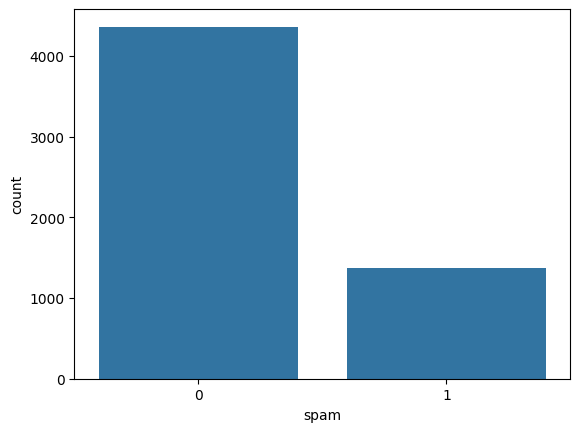

In [30]:
sns.countplot(x='spam', data=data)
plt.show()

Kita dapat melihat dengan jelas bahwa jumlah sampel Ham jauh lebih banyak dibandingkan dengan Spam yang berarti bahwa dataset yang kita gunakan tidak seimbang. Sehingga perlu dilakukan downsampling agar seimbang sehingga model akan dapat mengerti lebih baik.

**Downsampling the dataset**

In [31]:
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

**Plotting the counts of down sampled dataset**

Text(0.5, 0, 'Message types')

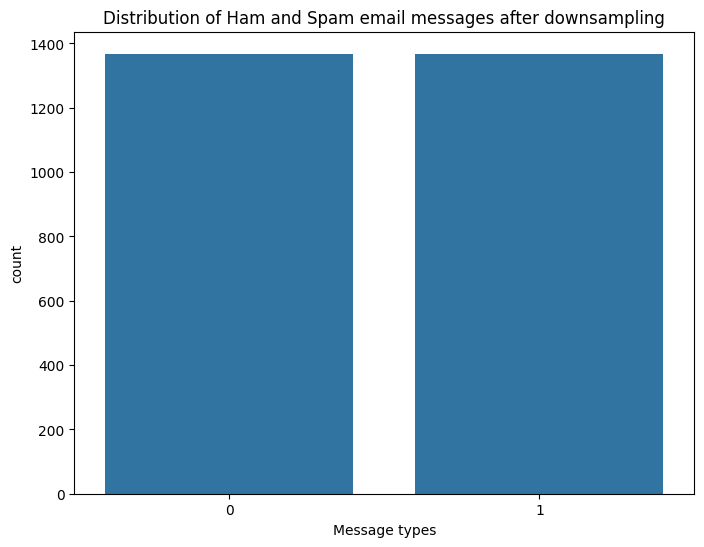

In [32]:
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


Meskipun menghapus data berarti kehilangan informasi, kita perlu melakukan hal ini agar data tersebut sempurna untuk dimasukkan ke dalam model pembelajaran mesin.

**Removing "Subject" word from text column**

In [33]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


**Removing Punctuation from Text Column**

In [34]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


**Removing the stopwords**

In [35]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


**Train-Test Split**

In [36]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


<h3>Word to vector conversion<h3>

kita tidak dapat memasukkan kata-kata ke dalam model pembelajaran mesin karena model tersebut hanya bekerja pada angka. Jadi, pertama-tama, kita akan mengubah kata-kata kita menjadi vektor dengan ID token menjadi kata-kata yang sesuai dan setelah mengisinya, data tekstual kita akan sampai ke tahap di mana kita dapat memasukkannya ke dalam model.

**Tokenization and Padding**

In [37]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len, 
								padding='post', 
								truncating='post')
test_sequences = pad_sequences(test_sequences, 
							maxlen=max_len, 
							padding='post', 
							truncating='post')


<h3> Model Development and Evaluation <h3>

kita akan menerapkan model Sequential yang akan berisi bagian-bagian berikut:

1. Tiga Lapisan Penyematan untuk mempelajari representasi vektor unggulan dari vektor masukan.
2. Lapisan LSTM untuk mengidentifikasi pola yang berguna dalam urutan.
3. Kemudian kita akan memiliki satu lapisan yang terhubung sepenuhnya.
4. Lapisan terakhir adalah lapisan keluaran yang mengeluarkan probabilitas untuk kedua kelas.

**Build the model**

In [38]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16, return_sequences=True))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           805024    
                                                                 
 lstm_1 (LSTM)               (None, 100, 16)           3136      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 813473 (3.10 MB)
Trainable params: 81347

**Compile the model**

In [39]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


**Callbacks**

In [40]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)
log_dir = "logs/fit"  # Tentukan direktori untuk menyimpan log TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

**Train the model**

In [41]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20, 
					batch_size=32,
					callbacks = [tensorboard_callback, lr, es]
				)


Epoch 1/20
69/69 [==============================] - 5s 45ms/step - loss: 0.5688 - accuracy: 0.7038 - val_loss: 0.1710 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 2s 32ms/step - loss: 0.1272 - accuracy: 0.9676 - val_loss: 0.1175 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 2s 33ms/step - loss: 0.0573 - accuracy: 0.9867 - val_loss: 0.1051 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 2s 30ms/step - loss: 0.0229 - accuracy: 0.9954 - val_loss: 0.0880 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 2s 29ms/step - loss: 0.0136 - accuracy: 0.9977 - val_loss: 0.1157 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 2s 29ms/step - loss: 0.0098 - accuracy: 0.9986 - val_loss: 0.1245 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 2s 29ms/step - loss: 0.0

**Showing in TensorBoard**

In [42]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 52867), started 0:00:38 ago. (Use '!kill 52867' to kill it.)

**Evaluate The Model**

In [43]:

test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


18/18 [==============================] - 0s 8ms/step - loss: 0.0880 - accuracy: 0.9781
Test Loss : 0.08803476393222809
Test Accuracy : 0.9781022071838379


**Training proggress graph**

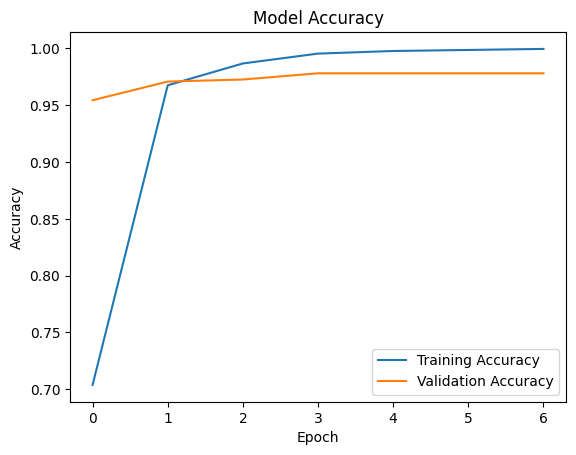

In [44]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
